## Initial setup

In [29]:
# @title Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate tensorboard transformers ftfy gradio
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes



In [2]:
#@title [Optional] Install xformers for faster and memory efficient training
#@markdown Acknowledgement: The xformers wheel are taken from [TheLastBen/fast-stable-diffusion](https://github.com/TheLastBen/fast-stable-diffusion). Thanks a lot for building these wheels!
# %%time

!pip install -U --pre triton


from subprocess import getoutput
from IPython.display import HTML
from IPython.display import clear_output
import time

s = getoutput('nvidia-smi')
print(s)

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Wed Apr 16 11:11:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:0A:00.0 Off |                    0 |
| N/A   44C    P0            256W /  700W |   78817MiB /  81559MiB |     54%      Default |
|                                         |                        

In [3]:
import sys
print("bitsandbytes" in sys.modules)  # Should output False


False


In [4]:
#@title Import required libraries
import argparse
import itertools
import math
import os
from contextlib import nullcontext
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed

from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

# # import bitsandbytes as bnb

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
import sys
print("bitsandbytes" in sys.modules)  # Should output False


False


## Settings for teaching your new concept

In [6]:
# #@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
# pretrained_model_name_or_path = "dreamlike-art/dreamlike-photoreal-2.0"
# # pretrained_model_name_or_path="stabilityai/stable-diffusion-2" #@param ["stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base", "CompVis/stable-diffusion-v1-4", "runwayml/stable-diffusion-v1-5"] {allow-input: true}

In [ ]:

"""The settings for models are present in cell named ALL MODELS present below."""
model='Stable_diffision_photoreal'
custom_vae=False
vae_type_EMA=True  #EMA produces sharper and more realistic images while MSE produces smoother and less noisy images
custom_text_encoder=False

In [ ]:
#@title Settings for your newly created concept
#@markdown `instance_prompt` is a prompt that should contain a good description of what your object or style is, together with the initializer word `cat_toy`  
# instance_prompt ="<ranbaji> Ranveer Singh" #@param {type:"string"}
instance_prompt="<bajiface> person" #@param {type:"string"}
 #"<RVS_Bcbm> Ranveer Singh" #@param {type:"string"}
#@markdown Check the `prior_preservation` option if you would like class of the concept (e.g.: toy, dog, painting) is guaranteed to be preserved. This increases the quality and helps with generalization at the cost of training time
prior_preservation =    False#@param {type:"boolean"}
prior_preservation_class_prompt = "photo of Ranveer Singh" #@param {type:"string"}

num_class_images = 100
sample_batch_size = 2
prior_loss_weight = 0.3
prior_preservation_class_folder ="/mnt/local/Dreamlike_Diffusion_Pipeline/dataset/class_images"
class_data_root=prior_preservation_class_folder
class_prompt=prior_preservation_class_prompt

## Teach the model the new concept (fine-tuning with Dreambooth)
Execute this this sequence of cells to run the training process. The whole process may take from 15 min to 2 hours. (Open this block if you are interested in how this process works under the hood or if you want to change advanced training settings or hyperparameters)

In [14]:
#@title Setup the Classes
from pathlib import Path
from torchvision import transforms

class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=True,
    ):
        # self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            print(f"Instance images root {self.instance_data_root} doesn't exists.")
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(Path(class_data_root).iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids
        
        return example


class PromptDataset(Dataset):
    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example

In [15]:
# #@title Generate Class Images
"""After running it restart the kernel and comment it out."""
# import gc
# if(prior_preservation):
#     class_images_dir = Path(class_data_root)
#     if not class_images_dir.exists():
#         class_images_dir.mkdir(parents=True)
#     cur_class_images = len(list(class_images_dir.iterdir()))

#     if cur_class_images < num_class_images:
#         pipeline = DiffusionPipeline.from_pretrained("dreamlike-art/dreamlike-photoreal-2.0").to(
#           "cuda"
#         )
#         pipeline.enable_attention_slicing()
#         pipeline.set_progress_bar_config(disable=True)

#         num_new_images = num_class_images - cur_class_images
#         print(f"Number of class images to sample: {num_new_images}.")

#         sample_dataset = PromptDataset(class_prompt, num_new_images)
#         sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=sample_batch_size)

#         for example in tqdm(sample_dataloader, desc="Generating class images"):
#             images = pipeline(example["prompt"]).images

#             for i, image in enumerate(images):
#                 image.save(class_images_dir / f"{example['index'][i] + cur_class_images}.jpg")
#         pipeline = None
#         gc.collect()
#         del pipeline
#         with torch.no_grad():
#           torch.cuda.empty_cache()

'After running it restart the kernel and comment it out.'

In [ ]:
"""ALL MODELS"""

import torch
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
)
from transformers import CLIPTextModel, CLIPTokenizer, T5EncoderModel

def load_stable_diffusion_components(model):
    """
    Load components for different Stable Diffusion models
    
    Args:
        model (str): Name of the model to load
    
    Returns:
        tuple: (vae, text_encoder, unet, tokenizer) for the specified model
    """
    
    if model == 'Stable_diffision_photoreal':
        pretrained_model_name_or_path = "dreamlike-art/dreamlike-photoreal-2.0"
        
        # MERITS: Highly photorealistic outputs, good for realistic scenes/portraits
        # DEMERITS: Tends to generate NSFW content, larger file size (2.13GB)
        
        # Load VAE - improved photorealism with better color reproduction
        vae = AutoencoderKL.from_pretrained(
            pretrained_model_name_or_path, 
            subfolder="vae",
            # torch_dtype=torch.float16
        )
        
        # Load text encoder - based on CLIP from SD 1.5
        text_encoder = CLIPTextModel.from_pretrained(
            pretrained_model_name_or_path, 
            subfolder="text_encoder",
            # torch_dtype=torch.float16
        )
        
        # Load UNet - fine-tuned for photorealism
        unet = UNet2DConditionModel.from_pretrained(
            pretrained_model_name_or_path, 
            subfolder="unet",
            # torch_dtype=torch.float16
        )
        
        # Load tokenizer - standard SD 1.5 tokenizer
        tokenizer = CLIPTokenizer.from_pretrained(
            pretrained_model_name_or_path, 
            subfolder="tokenizer"
        )
        
        print("Dreamlike Photoreal 2.0 components loaded successfully")
        print("TIP: Add 'photo' to your prompt for enhanced photorealism")
        print("WARNING: Add 'nude, naked' to negative prompt to avoid NSFW content")
        print("OPTIMAL RESOLUTION: 768x768px (model training resolution)")
        
    elif model == 'Stable_diffision_dreamlike':
        pretrained_model_name_or_path = "dreamlike-art/dreamlike-diffusion-1.0"
        
        # MERITS: Excellent for artistic, stylized images, better color grading
        # DEMERITS: Less realistic than photoreal, still based on older SD 1.5 architecture
        
        # Load VAE - standard SD 1.5 VAE with artistic tuning
        if(custom_vae):
            if(vae_type_EMA):
                vae =AutoencoderKL.from_pretrained(
                    "stabilityai/sd-vae-ft-ema",
                    # torch_dtype=torch.float16
                    )
            else:
                vae =AutoencoderKL.from_pretrained(
                    "stabilityai/sd-vae-ft-mse",
                    # torch_dtype=torch.float16
                    )
        else:
            vae = AutoencoderKL.from_pretrained(
                pretrained_model_name_or_path, 
                subfolder="vae",
                # torch_dtype=torch.float16
            )
        
        # Load text encoder - standard CLIP with better artistic prompt understanding
        text_encoder = CLIPTextModel.from_pretrained(
            pretrained_model_name_or_path, 
            subfolder="text_encoder",
            # torch_dtype=torch.float16
        )
        
        # Load UNet - fine-tuned for artistic styles
        unet = UNet2DConditionModel.from_pretrained(
            pretrained_model_name_or_path, 
            subfolder="unet",
            # torch_dtype=torch.float16
        )
        
        # Load tokenizer - standard SD 1.5 tokenizer
        tokenizer = CLIPTokenizer.from_pretrained(
            pretrained_model_name_or_path, 
            subfolder="tokenizer"
        )
        
        print("Dreamlike Diffusion 1.0 components loaded successfully")
        print("TIP: Add 'dreamlikeart' to your prompt to enhance artistic style")
        print("OPTIMAL RESOLUTION: 640x640px or 512x768px for better results")
        
    elif model == 'Stable_diffision_2':
        pretrained_model_name_or_path = "stabilityai/stable-diffusion-2"
        
        # MERITS: Improved generation quality over SD 1.5, better composition
        # DEMERITS: Larger model size, requires more memory than SD 1.5
        
        # Load VAE - improved color reproduction and detail preservation
        if(custom_vae):
            if(vae_type_EMA):
                vae =AutoencoderKL.from_pretrained(
                    "stabilityai/sd-vae-ft-ema",
                    # torch_dtype=torch.float16
                    )
            else:
                vae =AutoencoderKL.from_pretrained(
                    "stabilityai/sd-vae-ft-mse",
                    # torch_dtype=torch.float16
                    )
        else:
            vae = AutoencoderKL.from_pretrained(
                pretrained_model_name_or_path, 
                subfolder="vae",
                # torch_dtype=torch.float16
            )
        
        if(custom_text_encoder):
            model_id = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
            tokenizer = CLIPTokenizer.from_pretrained(model_id)
            text_encoder = CLIPTextModel.from_pretrained(model_id)
        else:
            # Load text encoder - improved CLIP model
            text_encoder = CLIPTextModel.from_pretrained(
                pretrained_model_name_or_path, 
                subfolder="text_encoder",
                # torch_dtype=torch.float16
            )
            # Load tokenizer - standard tokenizer
            tokenizer = CLIPTokenizer.from_pretrained(
                pretrained_model_name_or_path, 
                subfolder="tokenizer"
            )
        
        # Load UNet - improved architecture for better coherence
        unet = UNet2DConditionModel.from_pretrained(
            pretrained_model_name_or_path, 
            subfolder="unet",
            # torch_dtype=torch.float16
        )
        
        
        
        print("Stable Diffusion 2 components loaded successfully")
        print("OPTIMAL RESOLUTION: 512x512px or 768x768px")
        
    # elif model == 'Stable_diffision_3':
    #     pretrained_model_name_or_path = 'stabilityai/stable-diffusion-3-medium-diffusers'
        
    #     # MERITS: Superior text understanding, improved generation quality, better typography
    #     # DEMERITS: Very resource-intensive, requires model offloading, more complex architecture
        
    #     # Using DiffusionPipeline for SD3 as it has a unique architecture with three text encoders
    #     # and requires special handling
    #     pipe = DiffusionPipeline.from_pretrained(
    #         pretrained_model_name_or_path,
    #         torch_dtype=torch.float16,
    #         variant="fp16"
    #     )
        
    #     # For SD3, we'll extract components from the pipeline
    #     # Note: SD3 uses a different architecture with multiple text encoders
    #     vae = pipe.vae
        
    #     # SD3 uses 3 text encoders - we'll return the primary one
    #     # In practice, you should use all three as designed in the pipeline
    #     text_encoder = pipe.text_encoder
        
    #     # The UNet in SD3 is based on rectified flow transformers
    #     unet = pipe.unet
        
    #     # SD3 uses a different tokenizer system
    #     tokenizer = pipe.tokenizer
        
    #     print("Stable Diffusion 3 components loaded successfully")
    #     print("WARNING: SD3 uses three text encoders - this implementation returns only the primary one")
    #     print("NOTE: Model offloading is necessary to run on most commodity hardware")
    #     print("ARCHITECTURE: Based on rectified flow transformers with bidirectional image-text flow")
        
    # elif model == 'Stable_diffision_XL':
    #     pretrained_model_name_or_path = "stabilityai/stable-diffusion-xl-base-1.0"
        
    #     # MERITS: Higher quality outputs, better composition and details, dual text encoders
    #     # DEMERITS: Very high memory requirements, slower inference
        
    #     # SDXL uses a specialized VAE optimized for higher resolution
    #     if(custom_vae):
    #         vae =AutoencoderKL.from_pretrained(
    #             "madebyollin/sdxl-vae-fp16-fix",
    #             torch_dtype=torch.float16
    #             )
    #     else:
    #         vae = AutoencoderKL.from_pretrained(
    #             pretrained_model_name_or_path, 
    #             subfolder="vae",
    #             torch_dtype=torch.float16
    #         )

    #     # SDXL uses two text encoders: OpenCLIP-ViT/G and CLIP-ViT/L
    #     # Here we're loading the primary one (OpenCLIP)
    #     text_encoder = CLIPTextModel.from_pretrained(
    #         pretrained_model_name_or_path,
    #         subfolder="text_encoder",
    #         torch_dtype=torch.float16
    #     )
    #     # The secondary text encoder is loaded separately
    #     text_encoder_2 = CLIPTextModel.from_pretrained(
    #         pretrained_model_name_or_path,
    #         subfolder="text_encoder",
    #         revision="secondary"
    #     )
    #     # Note: The secondary text encoder is not returned in this implementation
        
    #     # SDXL's UNet is significantly larger than previous models
    #     unet = UNet2DConditionModel.from_pretrained(
    #         pretrained_model_name_or_path,
    #         subfolder="unet",
    #         torch_dtype=torch.float16
    #     )
        
    #     # Load the primary tokenizer (for the first text encoder)
    #     tokenizer = CLIPTokenizer.from_pretrained(
    #         pretrained_model_name_or_path,
    #         subfolder="tokenizer"
    #     )
    #     # Load the secondary tokenizer (for the second text encoder)
    #     tokenizer_2 = CLIPTokenizer.from_pretrained(
    #         pretrained_model_name_or_path,
    #         subfolder="tokenizer",
    #         revision="secondary"
    #     )
        
    #     print("Stable Diffusion XL components loaded successfully")
    #     print("NOTE: SDXL uses dual text encoders - this implementation returns only the primary one")
    #     print("OPTIMAL RESOLUTION: 1024x1024px")
    #     print("TIP: SDXL works well with a refinement model for enhanced details")
        
    else:
        raise ValueError(f"Model {model} not recognized")
    
    return vae, text_encoder, unet, tokenizer,pretrained_model_name_or_path



# Example usage:
if model != 'Stable_diffision_XL' or model != 'Stable_diffision_3':
    vae, text_encoder, unet, tokenizer, pretrained_model_name_or_path = load_stable_diffusion_components(model)
else:
    # For SDXL, we need to handle the dual text encoders and tokenizers
    vae, text_encoder,text_encoder1, unet, tokenizer,tokenizer_1,pretrained_model_name_or_path = load_stable_diffusion_components("Stable_diffision_photoreal")


In [ ]:
#@title Load the Stable Diffusion model
# # Load models and create wrapper for stable diffusion
# from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, DiffusionPipeline, UNet2DConditionModel

# text_encoder = CLIPTextModel.from_pretrained(
#     pretrained_model_name_or_path, subfolder="text_encoder"
# )
# vae = AutoencoderKL.from_pretrained(
#     pretrained_model_name_or_path, subfolder="vae"
# )
# unet = UNet2DConditionModel.from_pretrained(
#     pretrained_model_name_or_path, subfolder="unet"
# )
# tokenizer = CLIPTokenizer.from_pretrained(
#     pretrained_model_name_or_path,
#     subfolder="tokenizer",
# )

In [ ]:
# from argparse import Namespace
# args = Namespace(
#     pretrained_model_name_or_path=pretrained_model_name_or_path,
#     resolution=vae.sample_size,
#     center_crop=True,
#     train_text_encoder=False,
#     instance_data_dir="/mnt/local/swathi/bajirao_scene1",
#     instance_prompt=instance_prompt,
#     learning_rate=5e-04,
#     max_train_steps=200,
#     save_steps=200,
#     train_batch_size=1, # set to 1 if using prior preservation
#     gradient_accumulation_steps=2,#Since text encoder is trained, we need to set gradient_accumulation_steps=1
#     max_grad_norm=1.0,
#     mixed_precision="fp16", # set to "fp16" for mixed-precision training.
#     gradient_checkpointing=True, # set this to True to lower the memory usage.
#     use_8bit_adam=False, # use 8bit optimizer from bitsandbytes
#     seed=3434554,
#     with_prior_preservation=prior_preservation, 
#     prior_loss_weight=prior_loss_weight,
#     sample_batch_size=2,
#     class_data_dir=prior_preservation_class_folder, 
#     class_prompt=prior_preservation_class_prompt, 
#     num_class_images=num_class_images, 
#     lr_scheduler="constant",
#     lr_warmup_steps=10,
#     output_dir="dreambooth-concept_bajiface",
# )

In [ ]:
#@title Setting up all training args
from argparse import Namespace
args = Namespace(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    resolution=vae.sample_size,
    center_crop=False,
    train_text_encoder=False,
    instance_data_dir="  ", #PUT THE PATH TO YOUR INSTANCE DATA HERE
    instance_prompt=instance_prompt,
    learning_rate=5e-05,
    max_train_steps=1000,
    save_steps=200,
    train_batch_size=1, # set to 1 if using prior preservation
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    mixed_precision="no", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=False, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    with_prior_preservation=prior_preservation, 
    prior_loss_weight=prior_loss_weight,
    sample_batch_size=2,
    class_data_dir=prior_preservation_class_folder, 
    class_prompt=prior_preservation_class_prompt, 
    num_class_images=num_class_images, 
    lr_scheduler="constant",
    lr_warmup_steps=100,
    output_dir="output_directory",   #PUT THE OUTPUT DIRECTORY HERE
)

/tmp/ipykernel_2489560/352435209.py:5: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  resolution=vae.sample_size,


In [ ]:
"""CODE WITHOUT VAE TRAINING"""
#@title Training function
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, DiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from accelerate.utils import set_seed
import bitsandbytes as bnb
# import os
#@title Training function
from accelerate.utils import set_seed
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    set_seed(args.seed)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    # Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
    # This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
    # TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
    if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
        raise ValueError(
            "Gradient accumulation is not supported when training the text encoder in distributed training. "
            "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
        )

    vae.requires_grad_(False)
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW
    
    params_to_optimize = (
        itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
    )

    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler.from_config(args.pretrained_model_name_or_path, subfolder="scheduler")
    
    train_dataset = DreamBoothDataset(
        instance_data_root=args.instance_data_dir,
        instance_prompt=args.instance_prompt,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
        class_prompt=args.class_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]

        # concat class and instance examples for prior preservation
        if args.with_prior_preservation:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            return_tensors="pt",
            max_length=tokenizer.model_max_length
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch
    
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
    
    # Move text_encode and vae to gpu.
    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to("cpu")
    if not args.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)
    
    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)
  
    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                if args.with_prior_preservation:
                    # Chunk the noise and noise_pred into two parts and compute the loss on each part separately.
                    noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
                    target, target_prior = torch.chunk(target, 2, dim=0)

                    # Compute instance loss
                    loss = F.mse_loss(noise_pred.float(), target.float(), reduction="none").mean([1, 2, 3]).mean()

                    # Compute prior loss
                    prior_loss = F.mse_loss(noise_pred_prior.float(), target_prior.float(), reduction="mean")

                    # Add the prior loss to the instance loss.
                    loss = loss + args.prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")

                accelerator.backward(loss)
                
                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(unet.parameters(), text_encoder.parameters())
                        if args.train_text_encoder
                        else unet.parameters()
                    )
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if global_step % args.save_steps == 0:
                    if accelerator.is_main_process:
                        pipeline = DiffusionPipeline.from_pretrained(
                            args.pretrained_model_name_or_path,
                            unet=accelerator.unwrap_model(unet),
                            text_encoder=accelerator.unwrap_model(text_encoder),
                        )
                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        pipeline.save_pretrained(save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()
    
    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = DiffusionPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(text_encoder),
        )
        pipeline.save_pretrained(args.output_dir)

In [ ]:
"""CODE FOR TRAINING WITH VAE"""

# #@title Training function with vae training
# from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, DiffusionPipeline, UNet2DConditionModel
# from diffusers.optimization import get_scheduler
# from accelerate.utils import set_seed
# # import bitsandbytes as bnb
# # import os
# # def training_function():
# def training_function(text_encoder, vae, unet):
   
#     # import bitsandbytes
#     logger = get_logger(__name__)

#     set_seed(args.seed)

#     accelerator = Accelerator(
#         gradient_accumulation_steps=args.gradient_accumulation_steps,
#         mixed_precision=args.mixed_precision,
#     )

#     # Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
#     # This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
#     # TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
#     if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
#         raise ValueError(
#             "Gradient accumulation is not supported when training the text encoder in distributed training. "
#             "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
#         )

#     vae.requires_grad_(False)
#     if not args.train_text_encoder:
#         text_encoder.requires_grad_(False)

#     if args.gradient_checkpointing:
#         unet.enable_gradient_checkpointing()
#         if args.train_text_encoder:
#             text_encoder.gradient_checkpointing_enable()

#     # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
#     import bitsandbytes as bnb
#     if args.use_8bit_adam:
#         optimizer_class = bnb.optim.AdamW8bit
#     else:
#         optimizer_class = torch.optim.AdamW
    
#     # params_to_optimize = #( Original code)
#     #     itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
#     # )

#     params_to_optimize = (
#         itertools.chain(vae.parameters(),unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else itertools.chain(vae.parameters(),unet.parameters())
#     )

#     optimizer = optimizer_class(
#         params_to_optimize,
#         lr=args.learning_rate,
        
#     )

#     noise_scheduler = DDPMScheduler.from_config(args.pretrained_model_name_or_path, subfolder="scheduler")
    
#     train_dataset = DreamBoothDataset(
#         instance_data_root=args.instance_data_dir,
#         instance_prompt=args.instance_prompt,
#         class_data_root=args.class_data_dir if args.with_prior_preservation else None,
#         class_prompt=args.class_prompt,
#         tokenizer=tokenizer,
#         size=args.resolution,
#         center_crop=args.center_crop,
#     )

#     def collate_fn(examples):
#         input_ids = [example["instance_prompt_ids"] for example in examples]
#         pixel_values = [example["instance_images"] for example in examples]

#         # concat class and instance examples for prior preservation
#         if args.with_prior_preservation:
#             input_ids += [example["class_prompt_ids"] for example in examples]
#             pixel_values += [example["class_images"] for example in examples]

#         pixel_values = torch.stack(pixel_values)
#         pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

#         input_ids = tokenizer.pad(
#             {"input_ids": input_ids},
#             padding="max_length",
#             return_tensors="pt",
#             max_length=tokenizer.model_max_length
#         ).input_ids

#         batch = {
#             "input_ids": input_ids,
#             "pixel_values": pixel_values,
#         }
#         return batch
    
#     train_dataloader = torch.utils.data.DataLoader(
#         train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
#     )

#     lr_scheduler = get_scheduler(
#         args.lr_scheduler,
#         optimizer=optimizer,
#         num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
#         num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
#     )

#     if args.train_text_encoder:
#         unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
#             unet, text_encoder, optimizer, train_dataloader, lr_scheduler
#         )
#     else:
#         # unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
#         #     unet, optimizer, train_dataloader, lr_scheduler
#         # )
#         vae,unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
#             vae,unet, optimizer, train_dataloader, lr_scheduler
#         )


#     weight_dtype = torch.float32
#     if accelerator.mixed_precision == "fp16":
#         weight_dtype = torch.float16
#     elif accelerator.mixed_precision == "bf16":
#         weight_dtype = torch.bfloat16
    
#     # Move text_encode and vae to gpu.
#     # For mixed precision training we cast the text_encoder and vae weights to half-precision
#     # as these models are only used for inference, keeping weights in full precision is not required.
#     vae.to(accelerator.device, dtype=weight_dtype)
#     # vae.decoder.to("cpu")
#     if not args.train_text_encoder:
#         text_encoder.to(accelerator.device, dtype=weight_dtype)
    
#     # We need to recalculate our total training steps as the size of the training dataloader may have changed.
#     num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
#     num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)
  
#     # Train!
#     total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

#     logger.info("***** Running training *****")
#     logger.info(f"  Num examples = {len(train_dataset)}")
#     logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
#     logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
#     logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
#     logger.info(f"  Total optimization steps = {args.max_train_steps}")
#     # Only show the progress bar once on each machine.
#     progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
#     progress_bar.set_description("Steps")
#     global_step = 0
 
#     for epoch in range(num_train_epochs):
#         unet.train()
#         for step, batch in enumerate(train_dataloader):
#             with accelerator.accumulate(unet):
#                 # Convert images to latent space
#                 latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
#                 latents = latents * 0.18215

#                 # Sample noise that we'll add to the latents
#                 noise = torch.randn_like(latents)
#                 bsz = latents.shape[0]
#                 # Sample a random timestep for each image
#                 timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
#                 timesteps = timesteps.long()

#                 # Add noise to the latents according to the noise magnitude at each timestep
#                 # (this is the forward diffusion process)
#                 noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

#                 # Get the text embedding for conditioning
#                 encoder_hidden_states = text_encoder(batch["input_ids"])[0]

#                 # Predict the noise residual
#                 noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

#                 # Get the target for loss depending on the prediction type
#                 if noise_scheduler.config.prediction_type == "epsilon":
#                     target = noise
#                 elif noise_scheduler.config.prediction_type == "v_prediction":
#                     target = noise_scheduler.get_velocity(latents, noise, timesteps)
#                 else:
#                     raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

#                 if args.with_prior_preservation:
#                     # Chunk the noise and noise_pred into two parts and compute the loss on each part separately.
#                     noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
#                     target, target_prior = torch.chunk(target, 2, dim=0)

#                     # Compute instance loss
#                     loss = F.mse_loss(noise_pred.float(), target.float(), reduction="none").mean([1, 2, 3]).mean()

#                     # Compute prior loss
#                     prior_loss = F.mse_loss(noise_pred_prior.float(), target_prior.float(), reduction="mean")

#                     # Add the prior loss to the instance loss.
#                     loss = loss + args.prior_loss_weight * prior_loss
#                 else:
#                     loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")

#                 accelerator.backward(loss)
                
#                 if accelerator.sync_gradients:
#                     # params_to_clip = (
#                     #     itertools.chain(unet.parameters(), text_encoder.parameters())
#                     #     if args.train_text_encoder
#                     #     else unet.parameters()
#                     # )
#                     params_to_clip = (
#                         itertools.chain(vae.parameters(),unet.parameters(), text_encoder.parameters())
#                         if args.train_text_encoder
#                         else itertools.chain(vae.parameters(),unet.parameters())
#                     )
#                     accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
#                 optimizer.step()
#                 optimizer.zero_grad()

#             # Checks if the accelerator has performed an optimization step behind the scenes
#             if accelerator.sync_gradients:
#                 progress_bar.update(1)
#                 global_step += 1

#                 if global_step % args.save_steps == 0:
#                     if accelerator.is_main_process:
#                         pipeline = DiffusionPipeline.from_pretrained(
#                             args.pretrained_model_name_or_path,
#                             unet=accelerator.unwrap_model(unet),
#                             text_encoder=accelerator.unwrap_model(text_encoder),
#                             vae=accelerator.unwrap_model(vae),# extra
#                         )
#                         save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
#                         pipeline.save_pretrained(save_path)

#             logs = {"loss": loss.detach().item()}
#             progress_bar.set_postfix(**logs)

#             if global_step >= args.max_train_steps:
#                 break

#         accelerator.wait_for_everyone()
    
#     # Create the pipeline using using the trained modules and save it.
#     if accelerator.is_main_process:
#         pipeline = DiffusionPipeline.from_pretrained(
#             args.pretrained_model_name_or_path,
#             unet=accelerator.unwrap_model(unet),
#             text_encoder=accelerator.unwrap_model(text_encoder),
#             vae=accelerator.unwrap_model(vae),# extra
            
#         )
#         pipeline.save_pretrained(args.output_dir)

In [ ]:
#@title Run training
import accelerate
accelerate.notebook_launcher(training_function,num_processes=1, args=(text_encoder, vae, unet))
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.


/home/jovyan/anaconda3/envs/teja_finetune/lib/python3.13/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
"""Multiple gpus"""

# from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, DiffusionPipeline, UNet2DConditionModel

# text_encoder = CLIPTextModel.from_pretrained(
# pretrained_model_name_or_path, subfolder="text_encoder"
# )
# vae = AutoencoderKL.from_pretrained(
# pretrained_model_name_or_path, subfolder="vae"
# )
# unet = UNet2DConditionModel.from_pretrained(
# pretrained_model_name_or_path, subfolder="unet"
# )
# tokenizer = CLIPTokenizer.from_pretrained(
# pretrained_model_name_or_path,
# subfolder="tokenizer",
# )

# for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
#   if param.grad is not None:
#     del param.grad  # free some memory
#   torch.cuda.empty_cache()

'Multiple gpus'

## Run the code with your newly trained model
If you have just trained your model with the code above, use the block below to run it.

Also explore the [DreamBooth Concepts Library](https://huggingface.co/sd-dreambooth-library) 

In [ ]:
import os
import torch
from diffusers import DiffusionPipeline

# # Set the directory where your trained model is stored
model_directory = "/mnt/local/ImmersoAI/Dreamlike_Diffusion_Pipeline/training/dreambooth-concept-bajiface1"


In [ ]:
#@title Set up the pipeline 
from diffusers import DPMSolverMultistepScheduler
pipe = DiffusionPipeline.from_pretrained(
        model_directory,
        scheduler = DPMSolverMultistepScheduler.from_pretrained(model_directory, subfolder="scheduler"),
        torch_dtype=torch.float16,
    ).to("cuda")

In [ ]:
"""testing the model"""
#Instance prompt : # " <ranbaji> man" Me

prompt = "         " #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}


all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=100, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid


#EXPERIMENTS INFERENCE


  0%|          | 0/100 [00:00<?, ?it/s]

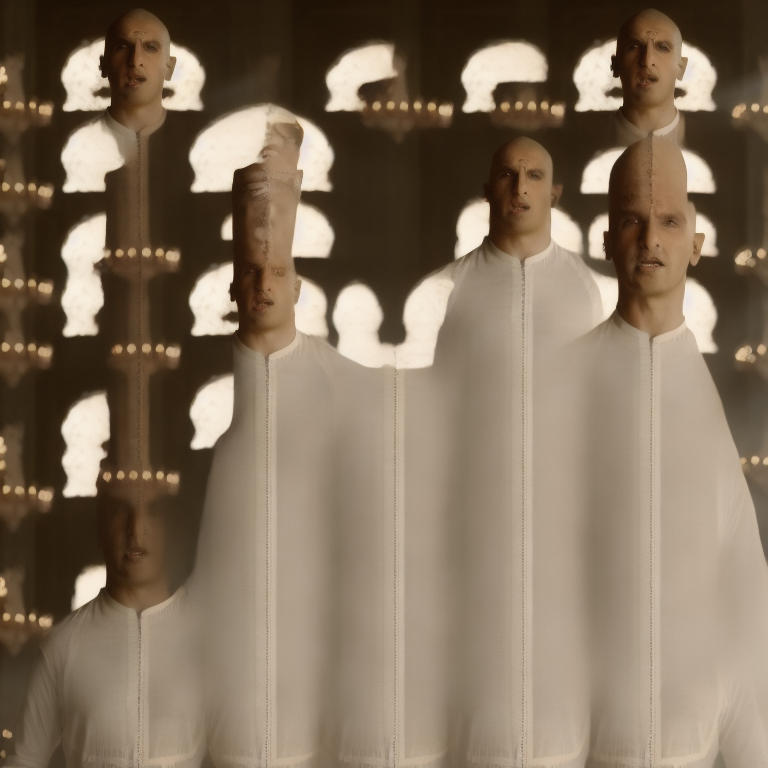

In [ ]:
#vae trained
#Instance prompt : # " <ranbaji> man" Me

prompt = "photo of <baji-face> with a crown" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}


all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=100, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid


In [ ]:
import os
import torch
from diffusers import DiffusionPipeline

# # Set the directory where your trained model is stored
model_directory = "/mnt/local/ImmersoAI/Dreamlike_Diffusion_Pipeline/training/dreambooth-concept-manu"



In [ ]:
#@title Set up the pipeline 
from diffusers import DPMSolverMultistepScheduler
pipe = DiffusionPipeline.from_pretrained(
        model_directory,
        scheduler = DPMSolverMultistepScheduler.from_pretrained(model_directory, subfolder="scheduler"),
        torch_dtype=torch.float16,
    ).to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

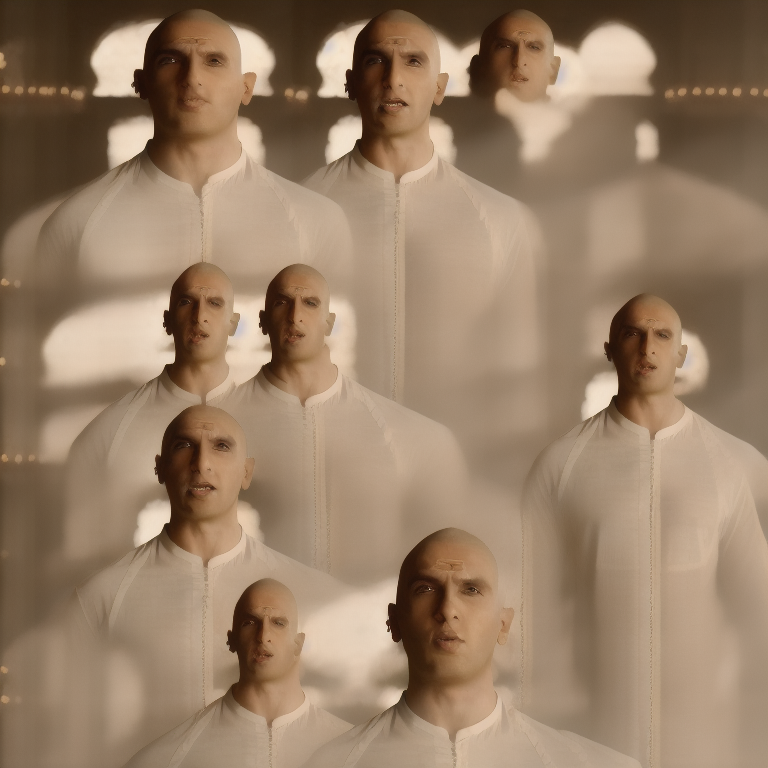

In [28]:
#vae trained
#Instance prompt : # " <ranbaji> man" Me

prompt = "photo of <baji-face>" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}


all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=100, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid


  0%|          | 0/100 [00:00<?, ?it/s]

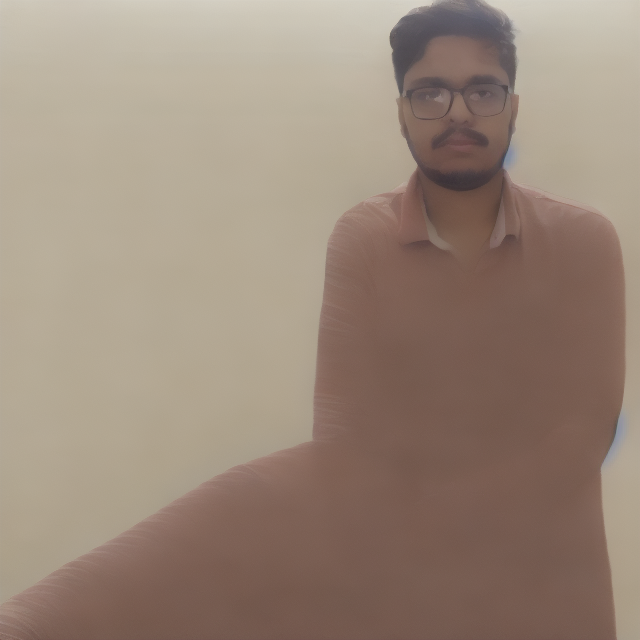

In [71]:
#vae trained
#Instance prompt : # " <ranbaji> man" Me

prompt = "photo of <manu>" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}


all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=100, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid


#Dreambooth Concept (Photo-real-2.0)



args = Namespace(
        pretrained_model_name_or_path=pretrained_model_name_or_path,
        resolution=vae.sample_size,
        center_crop=False,
        train_text_encoder=False,
        instance_data_dir="/mnt/local/Dreamlike_Diffusion_Pipeline/dataset/ranveer_face_images_4k_selected",
        instance_prompt=instance_prompt,
        learning_rate=1e-05,
        max_train_steps=1000,
        save_steps=200,
        train_batch_size=1, # set to 1 if using prior preservation
        # gradient_accumulation_steps=2,
        gradient_accumulation_steps=2,#Since text encoder is trained, we need to set gradient_accumulation_steps=1
        max_grad_norm=1.0,
        mixed_precision="fp16", # set to "fp16" for mixed-precision training.
        gradient_checkpointing=True, # set this to True to lower the memory usage.
        use_8bit_adam=False, # use 8bit optimizer from bitsandbytes
        seed=3434554,
        with_prior_preservation=prior_preservation, 
        prior_loss_weight=prior_loss_weight,
        sample_batch_size=2,
        class_data_dir=prior_preservation_class_folder, 
        class_prompt=prior_preservation_class_prompt, 
        num_class_images=num_class_images, 
        lr_scheduler="cosine",
        lr_warmup_steps=10,
        output_dir="dreambooth-concept",
    )

In [ ]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "picture of <RVS_Bcbm> Ranveer Singh" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

In [ ]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "front view picture of <RVS_Bcbm> Ranveer Singh riding a horse with king's attire " #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

In [ ]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "front view picture of <RVS_Bcbm> Ranveer Singh wearing white salwar  " #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

In [ ]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "front view picture of <RVS_Bcbm> Ranveer Singh wearing white salwar and guarded by men  " #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

Dreambooth Concept1 Photoreal 2 



    args = Namespace(
        pretrained_model_name_or_path=pretrained_model_name_or_path,
        resolution=vae.sample_size,
        center_crop=False,
        train_text_encoder=False,
        instance_data_dir="/mnt/local/Dreamlike_Diffusion_Pipeline/dataset/ranveer_face_images_4k_selected",
        instance_prompt=instance_prompt,
        learning_rate=1e-03,
        max_train_steps=10000,
        save_steps=200,
        train_batch_size=1, # set to 1 if using prior preservation
        # gradient_accumulation_steps=2,
        gradient_accumulation_steps=2,#Since text encoder is trained, we need to set gradient_accumulation_steps=1
        max_grad_norm=1.0,
        mixed_precision="fp16", # set to "fp16" for mixed-precision training.
        gradient_checkpointing=True, # set this to True to lower the memory usage.
        use_8bit_adam=False, # use 8bit optimizer from bitsandbytes
        seed=3434554,
        with_prior_preservation=prior_preservation, 
        prior_loss_weight=prior_loss_weight,
        sample_batch_size=2,
        class_data_dir=prior_preservation_class_folder, 
        class_prompt=prior_preservation_class_prompt, 
        num_class_images=num_class_images, 
        lr_scheduler="cosine",
        lr_warmup_steps=10,
        output_dir="dreambooth-concept1",
    )


In [ ]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "picture of <RVS_Bcbm> Ranveer Singh" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"numbaer"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

In [ ]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "front view picture of <RVS_Bcbm> Ranveer Singh riding a horse with king's attire " #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

In [ ]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "front view picture of <RVS_Bcbm> Ranveer Singh wearing white salwar  " #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

In [ ]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "front view picture of <RVS_Bcbm> Ranveer Singh wearing white salwar and guarded by men  " #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

Dreambooth concept3

In [ ]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "photo of \u003Cbaji-ranvi> person " #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

In [ ]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "photo of \baji-ranvi> person " #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid

The above generation implies that truth is bitter.

  0%|          | 0/100 [00:00<?, ?it/s]

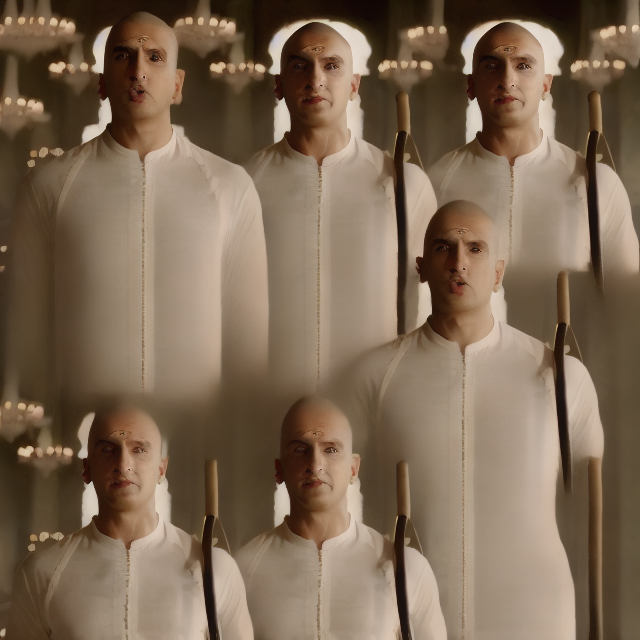

In [ ]:
#Training default vae


prompt = "photo of <ranbaji>" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}


all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=100, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid


  0%|          | 0/100 [00:00<?, ?it/s]

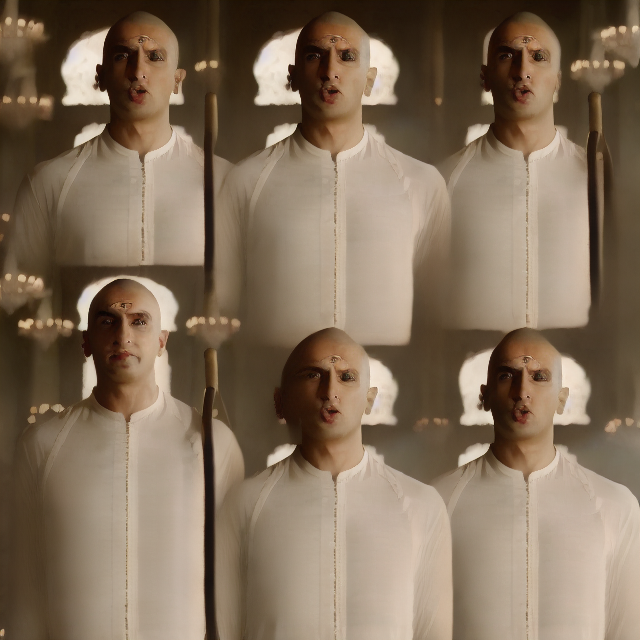

In [ ]:

#Training default vae

prompt = "photo of <ranbaji> Ranveer Singh" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}


all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=100, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid


  0%|          | 0/100 [00:00<?, ?it/s]

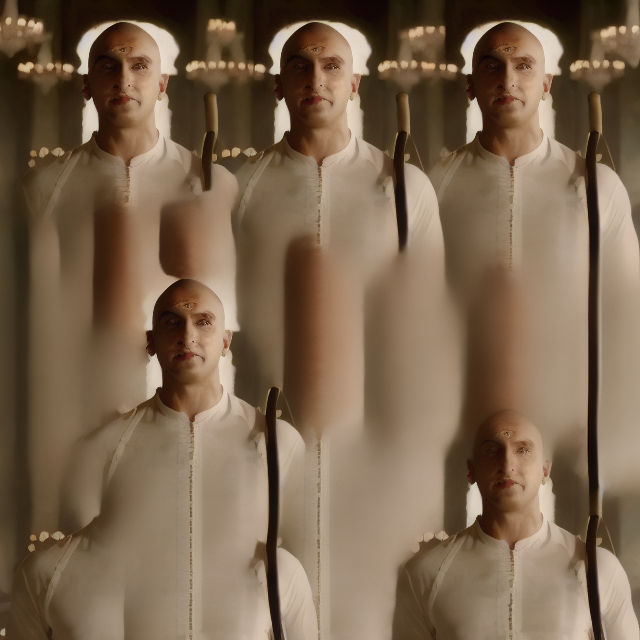

In [ ]:


#Instance prompt : # " <ranbaji> Ranveer Singh"
#Without training vae and default vae

prompt = "photo of <ranbaji> Ranveer Singh" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}


all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=100, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid


  0%|          | 0/100 [00:00<?, ?it/s]

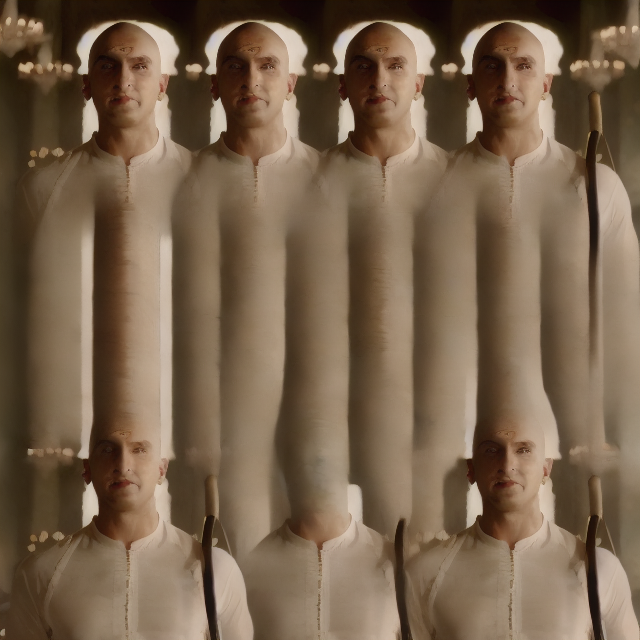

In [ ]:

#Instance prompt : # " <ranbaji> Ranveer Singh"
#Without training vae and default vae

prompt = "photo of <ranbaji> " #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}


all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=100, guidance_scale=9).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid


In [ ]:
#@title Set up the pipeline 
from diffusers import DPMSolverMultistepScheduler
pipe = DiffusionPipeline.from_pretrained(
        model_directory,
        # args.output_dir,
        #        scheduler = DPMSolverMultistepScheduler.from_pretrained(args.output_dir, subfolder="scheduler"),

        scheduler = DPMSolverMultistepScheduler.from_pretrained(model_directory, subfolder="scheduler"),
        torch_dtype=torch.float16,
    ).to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

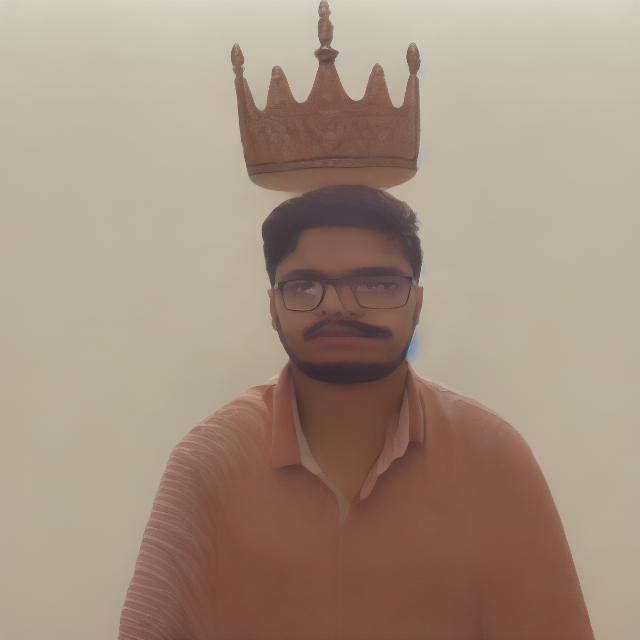

In [ ]:
#vae trained
#Instance prompt : # " <ranbaji> man" Me

prompt = "photo of <manu> with a crown on head" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}


all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid


  0%|          | 0/50 [00:00<?, ?it/s]

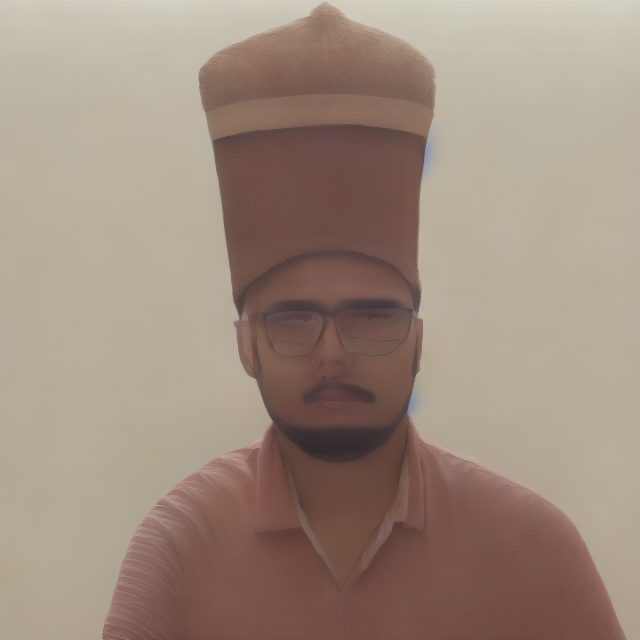

In [13]:
#vae trained
#Instance prompt : # " <ranbaji> man" Me

prompt = "photo of <manu> man with a crown on head" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}


all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid
